In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate, GridSearchCV

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

In [ ]:
TARGET_COL = "duration_minutes"
# remove duration in features to avoid data leakage
# remove genre_top in order because we drop outliers and reduce scope of targeted track genre
OTHERS = ["duration", "genre_top"]
TEST_SIZE = 0.2
N_SPLITS = 3

## Load merged dataset

In [3]:
df_train = pd.read_csv("../DataBase/processed/train_data.csv")
print(df_train.shape)

df_test = pd.read_csv("../DataBase/processed/test_data.csv")
print(df_test.shape)

(5493, 41)
(1374, 41)


## Data preprocessing

In [4]:
df_train = df_train[df_train[TARGET_COL].notna()].dropna().copy()
print(df_train.shape)

df_test = df_test[df_test[TARGET_COL].notna()].dropna().copy()
print(df_test.shape)

(5493, 41)
(1374, 41)


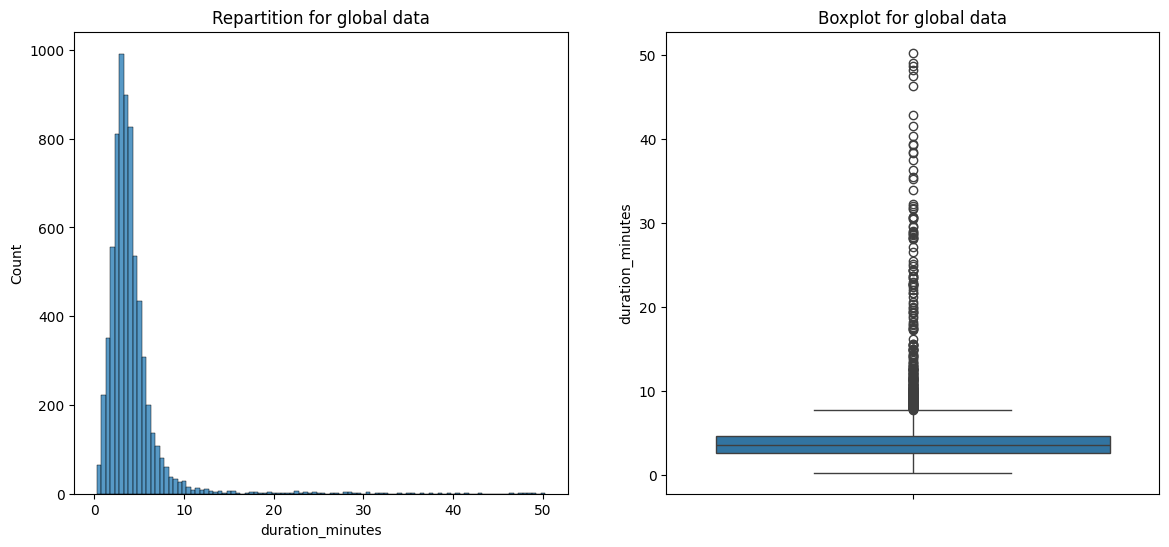

In [5]:
_, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(pd.concat([df_train[TARGET_COL], df_test[TARGET_COL]]), bins=100, ax=axes[0])
axes[0].set_title("Repartition for global data")
sns.boxplot(pd.concat([df_train[TARGET_COL], df_test[TARGET_COL]]), ax=axes[1])
axes[1].set_title("Boxplot for global data")
plt.show()

In [6]:
LIMIT_TIME_MIN, LIMIT_TIME_MAX = 1, 8
df_train = df_train[(df_train["duration_minutes"] <= LIMIT_TIME_MAX) & (df_train["duration_minutes"] >= LIMIT_TIME_MIN)]
df_test = df_test[(df_test["duration_minutes"] <= LIMIT_TIME_MAX) & (df_test["duration_minutes"] >= LIMIT_TIME_MIN)]

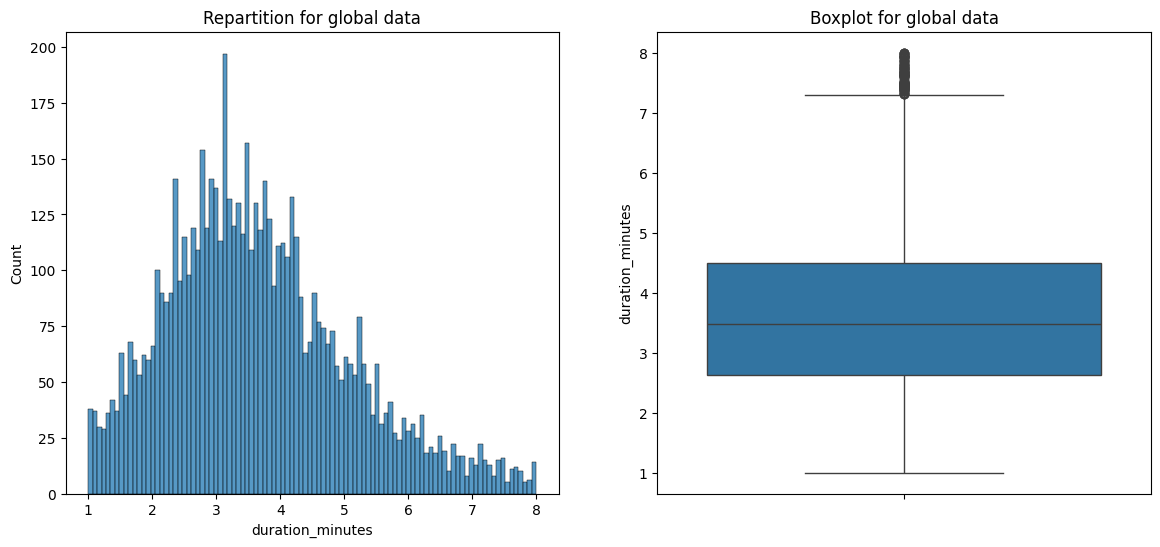

In [7]:
_, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(pd.concat([df_train[TARGET_COL], df_test[TARGET_COL]]), bins=100, ax=axes[0])
axes[0].set_title("Repartition for global data")
sns.boxplot(pd.concat([df_train[TARGET_COL], df_test[TARGET_COL]]), ax=axes[1])
axes[1].set_title("Boxplot for global data")
plt.show()

In [8]:
X_train, X_test = df_train.drop(columns=[TARGET_COL] + OTHERS), df_test.drop(columns=[TARGET_COL] + OTHERS)
y_train, y_test = df_train[TARGET_COL], df_test[TARGET_COL]

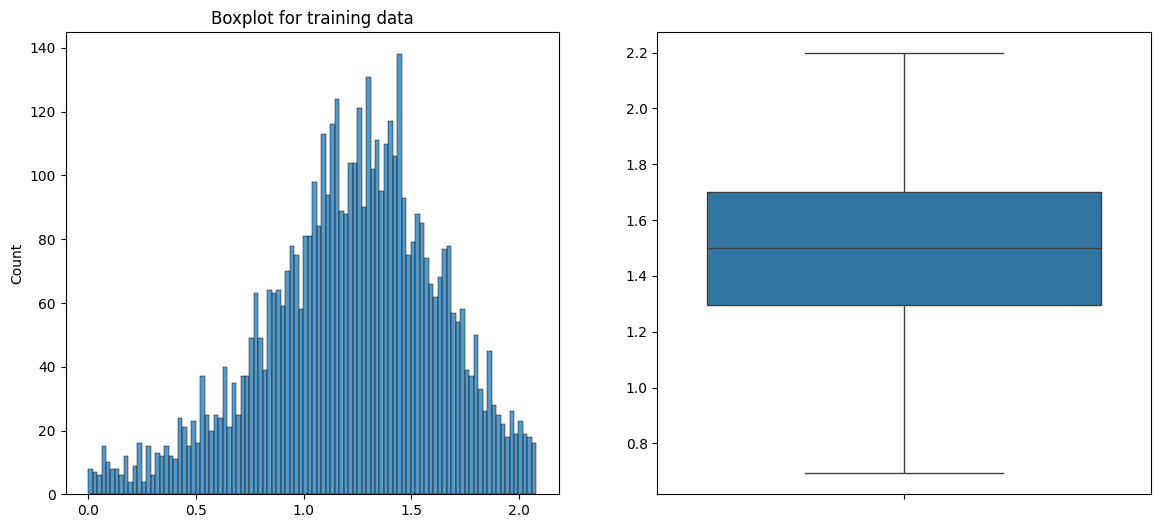

In [9]:
y_train_transformed = [np.log1p(value) for value in y_train]
y_test_transformed = [np.log1p(value) for value in y_test]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot([np.log(value) for value in y_train], bins=100, ax=axes[0])
axes[0].set_title("Repartition for training data")
sns.boxplot([np.log(value + 1) for value in y_train], ax=axes[1])
axes[0].set_title("Boxplot for training data")
plt.show()

## Model training

## With coarse_genre_top GroupKFold

In [10]:
kfolf = KFold(N_SPLITS)

In [11]:
def inv_transform(value):
    return np.exp(value) - 1

### SVM

In [12]:
svm = SVR()

svm.fit(X_train, y_train)

predictions = svm.predict(X_test)

print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, predictions):.4f}")
print(f"MSE: {mean_squared_error(y_test, predictions):.4f}")
print(f"r2: {r2_score(y_test, predictions):.4f}")

Metrics in original space:
RMSE: 1.4516
MSE: 2.1070
r2: 0.0231


In [13]:
svm = SVR()

svm.fit(X_train, y_train_transformed)

predictions = svm.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]

svm_rmse_transformed = root_mean_squared_error(y_test_transformed, predictions)
svm_mse_transformed = mean_squared_error(y_test_transformed, predictions)
svm_r2_transformed = r2_score(y_test_transformed, predictions)
print("Metrics in transformed space:")
print(f"RMSE: {svm_rmse_transformed:.4f}")
print(f"MSE: {svm_mse_transformed:.4f}")
print(f"r2: {svm_r2_transformed:.4f}")

print("----------------------")

svm_rmse = root_mean_squared_error(y_test, inv_predictions)
svm_mse = mean_squared_error(y_test, inv_predictions)
svm_r2 = r2_score(y_test, inv_predictions)
print("Metrics in original space:")
print(f"RMSE: {svm_rmse:.4f}")
print(f"MSE: {svm_mse:.4f}")
print(f"r2: {svm_r2:.4f}")

Metrics in transformed space:
RMSE: 0.3128
MSE: 0.0979
r2: 0.0393
----------------------
Metrics in original space:
RMSE: 1.4430
MSE: 2.0823
r2: 0.0345


Low performances, no need for hyperparameters search, it won't change the end result and the model will not be more usable. We will still perform a cross validation to definitely evaluate the SVM model.

In [14]:
scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error", "r2"]
scores = cross_validate(
	SVR(),
	X_train,
	y_train_transformed,
	cv=kfolf,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 0.2994 +- 0.0015
MSE: 0.0897 +- 0.0009
r2: 0.0349 +- 0.0043


### Random Forest

In [15]:
random_forest = RandomForestRegressor(random_state=42)

random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_test)
print(f"RMSE: {root_mean_squared_error(y_test, predictions):.4f}")
print(f"MSE: {mean_squared_error(y_test, predictions):.4f}")
print(f"r2: {r2_score(y_test, predictions):.4f}")

RMSE: 0.7152
MSE: 0.5115
r2: 0.7629


In [16]:
random_forest = RandomForestRegressor(random_state=42)

random_forest.fit(X_train, y_train_transformed)

predictions = random_forest.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]

print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE: {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")

print("----------------------")

print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE: {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.1544
MSE: 0.0238
r2: 0.7660
----------------------
Metrics in original space:
RMSE: 0.7144
MSE: 0.5104
r2: 0.7633


In [17]:
PARAM_GRID = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None], # None permet aux arbres de se développer pleinement
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=PARAM_GRID,
    cv= kfolf,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_transformed)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  14.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  14.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  14.8s
[CV] END max_depth=10, min_sa

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [18]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {-grid_search.best_score_:.4f}")

Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best CV score (based on training data): 0.1566


In [19]:
scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error", "r2"]
best_params = grid_search.best_params_
scores = cross_validate(
	RandomForestRegressor(random_state=42, **best_params),
	X_train,
	y_train_transformed,
	cv=kfolf,
	scoring=scoring
)

rf_fit_time = np.mean(scores["fit_time"])
print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 0.1566 +- 0.0023
MSE: 0.0245 +- 0.0007
r2: 0.7361 +- 0.0082


In [20]:
random_forest = RandomForestRegressor(
    random_state=42,
    **best_params,
)

random_forest.fit(X_train, y_train_transformed)

predictions = random_forest.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]

rf_rmse_transformed = root_mean_squared_error(y_test_transformed, predictions)
rf_mse_transformed = mean_squared_error(y_test_transformed, predictions)
rf_r2_transformed = r2_score(y_test_transformed, predictions)
print("Metrics in transformed space:")
print(f"RMSE: {rf_rmse_transformed:.4f}")
print(f"MSE: {rf_mse_transformed:.4f}")
print(f"r2: {rf_r2_transformed:.4f}")

print("----------------------")

rf_rmse = root_mean_squared_error(y_test, inv_predictions)
rf_mse = mean_squared_error(y_test, inv_predictions)
rf_r2 = r2_score(y_test, inv_predictions)
print("Metrics in original space:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MSE: {rf_mse:.4f}")
print(f"r2: {rf_r2:.4f}")

Metrics in transformed space:
RMSE: 0.1537
MSE: 0.0236
r2: 0.7680
----------------------
Metrics in original space:
RMSE: 0.7117
MSE: 0.5065
r2: 0.7652


### XGBoost

In [21]:
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train, y_train)

predictions = xgb.predict(X_test)
print(f"RMSE: {root_mean_squared_error(y_test, predictions):.4f}")
print(f"MSE: {mean_squared_error(y_test, predictions):.4f}")
print(f"r2: {r2_score(y_test, predictions):.4f}")

RMSE: 0.7518
MSE: 0.5652
r2: 0.7379


In [22]:
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train, y_train_transformed)

predictions = xgb.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]

print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE: {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")

print("----------------------")

print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE: {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.1624
MSE: 0.0264
r2: 0.7411
----------------------
Metrics in original space:
RMSE: 0.7448
MSE: 0.5548
r2: 0.7428


In [23]:
PARAM_GRID = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 5],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=PARAM_GRID,
    cv= kfolf,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_transformed)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.7; total

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.9], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, ...], 'min_child_weight': [1, 5], ...}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [24]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {-grid_search.best_score_:.4f}")

Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (based on training data): 0.1570


In [25]:
best_params = grid_search.best_params_
scores = cross_validate(
	XGBRegressor(random_state=42, **best_params),
	X_train,
	y_train_transformed,
	cv=kfolf,
	scoring=scoring
)

xgb_fit_time = np.mean(scores["fit_time"])
print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 0.1570 +- 0.0027
MSE: 0.0247 +- 0.0009
r2: 0.7345 +- 0.0099


In [26]:
xgb = XGBRegressor(
    random_state=42,
    **best_params,
)

xgb.fit(X_train, y_train_transformed)

predictions = xgb.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]

xgb_rmse_transformed = root_mean_squared_error(y_test_transformed, predictions)
xgb_mse_transformed = mean_squared_error(y_test_transformed, predictions)
xgb_r2_transformed = r2_score(y_test_transformed, predictions)
print("Metrics in transformed space:")
print(f"RMSE: {xgb_rmse_transformed:.4f}")
print(f"MSE: {xgb_mse_transformed:.4f}")
print(f"r2: {xgb_r2_transformed:.4f}")

print("----------------------")

xgb_rmse = root_mean_squared_error(y_test, inv_predictions)
xgb_mse = mean_squared_error(y_test, inv_predictions)
xgb_r2 = r2_score(y_test, inv_predictions)
print("Metrics in original space:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MSE: {xgb_mse:.4f}")
print(f"r2: {xgb_r2:.4f}")

Metrics in transformed space:
RMSE: 0.1535
MSE: 0.0236
r2: 0.7687
----------------------
Metrics in original space:
RMSE: 0.7110
MSE: 0.5055
r2: 0.7656


## Comparaison

In [27]:
df_comparaison = pd.DataFrame(
    {
        "model": ["svm", "random_forest", "xgboost"],
        "rmse": [svm_rmse, rf_rmse, xgb_rmse],
        "mse": [svm_mse, rf_mse, xgb_mse],
        "r2": [svm_r2, rf_r2, xgb_r2],
        "rmse_transformed": [svm_rmse_transformed, rf_rmse_transformed, xgb_rmse_transformed],
        "mse_transformed": [svm_mse_transformed, rf_mse_transformed, xgb_mse_transformed],
        "r2_transformed": [svm_r2_transformed, rf_r2_transformed, xgb_r2_transformed],
    }
)

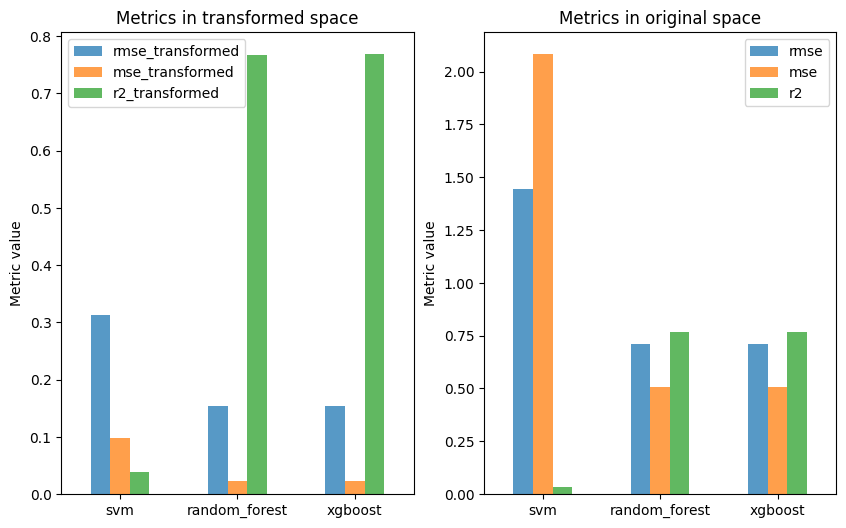

In [28]:
_, axes = plt.subplots(1, 2)

metrics_transformed = ["rmse_transformed", "mse_transformed", "r2_transformed"]
df_comparaison[metrics_transformed].plot(kind="bar", figsize=(10, 6), alpha=0.75, ax=axes[0])
axes[0].set_xticks(ticks=range(len(df_comparaison)), labels=df_comparaison["model"], rotation=0)
axes[0].set_ylabel("Metric value")
axes[0].set_title("Metrics in transformed space")

metrics = ["rmse", "mse", "r2"]
df_comparaison[metrics].plot(kind="bar", figsize=(10, 6), alpha=0.75, ax=axes[1])
axes[1].set_xticks(ticks=range(len(df_comparaison)), labels=df_comparaison["model"], rotation=0)
axes[1].set_ylabel("Metric value")
axes[1].set_title("Metrics in original space")

plt.show()

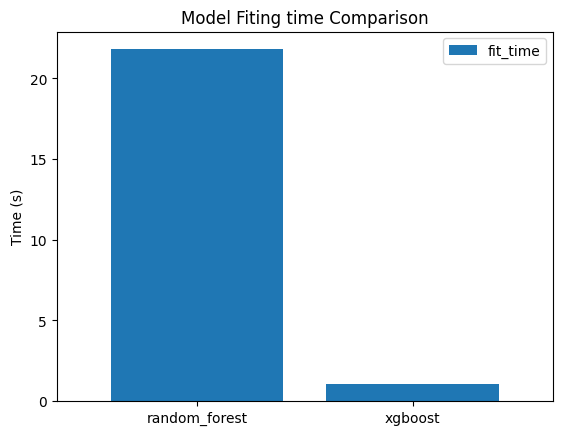

In [29]:
df_fit_time = pd.DataFrame({
    "model": ["random_forest", "xgboost"],
    "fit_time": [rf_fit_time, xgb_fit_time],
})

df_fit_time.plot(kind='bar', rot=0, title="Model Fiting time Comparison", width=0.8)

plt.xticks(ticks=range(len(df_fit_time)), labels=df_fit_time["model"], rotation=0)
plt.ylabel("Time (s)")

plt.show()